# IMPORTS

In [1]:
# Install transformer_lens if not already installed
# !pip install transformer_lens

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from transformer_lens import HookedTransformer, HookedTransformerConfig
from tqdm import tqdm

# Set seeds for reproducibility
torch.manual_seed(999)
np.random.seed(999)

# Configuration
device = "cuda" if torch.cuda.is_available() else "cpu"
P = 113
TRAIN_FRAC = 0.3
LR = 1e-3
WEIGHT_DECAY = 1.0 # High weight decay is essential for grokking
BETAS = (0.9, 0.98)
NUM_EPOCHS = 40000 # Usually happens between 10k and 25k epochs

print(f"Running on device: {device}")

Running on device: cuda


# DATASET

In [2]:
# 1. Dataset Generation
def gen_data(p):
    data = []
    # Generate all possible pairs
    for i in range(p):
        for j in range(p):
            # Format: [a, b, =] where '=' is represented by token P
            # Target: (a + b) % p
            seq = [i, j, p]
            label = (i + j) % p
            data.append((seq, label))
    return data

# Create data
data_pairs = gen_data(P)
full_data = torch.tensor([item[0] for item in data_pairs]).to(device)
full_labels = torch.tensor([item[1] for item in data_pairs]).to(device)

# Split Data (30% Training)
# We use a random permutation to select the subset
num_samples = len(full_data)
train_size = int(TRAIN_FRAC * num_samples)
indices = torch.randperm(num_samples)

train_indices = indices[:train_size]
test_indices = indices[train_size:]

train_data, train_labels = full_data[train_indices], full_labels[train_indices]
test_data, test_labels = full_data[test_indices], full_labels[test_indices]

print(f"Total samples: {num_samples}")
print(f"Training samples: {len(train_data)} ({TRAIN_FRAC*100}%)")
print(f"Test samples: {len(test_data)}")


Total samples: 12769
Training samples: 3830 (30.0%)
Test samples: 8939


# MODEL

In [3]:

# 2. Model Configuration
# Note: d_vocab is P+1 to account for the '=' token.
# d_vocab_out is P because the output is always a number 0..P-1
cfg = HookedTransformerConfig(
    n_layers = 1,
    n_heads = 4,
    d_model = 128,
    d_head = 32,
    d_mlp = 512,
    act_fn = "relu",
    normalization_type = None, # Crucial: No LayerNorm
    d_vocab = P+1,
    d_vocab_out = P,
    n_ctx = 3,
    init_weights = True,
    device = device,
    seed = 999,
)

model = HookedTransformer(cfg)

# 3. Freeze Biases
# We iterate through parameters and freeze anything that looks like a bias
for name, param in model.named_parameters():
    if "b_" in name:
        param.requires_grad = False
        param.fill_(0.0)
        print(f"Froze parameter: {name}")

print("Model initialized and biases frozen.")

Froze parameter: blocks.0.attn.b_Q
Froze parameter: blocks.0.attn.b_O
Froze parameter: blocks.0.attn.b_K
Froze parameter: blocks.0.attn.b_V
Froze parameter: blocks.0.mlp.b_in
Froze parameter: blocks.0.mlp.b_out
Froze parameter: unembed.b_U
Model initialized and biases frozen.


In [4]:
# 4. Custom Loss Function (High Precision)
def custom_cross_entropy(logits, labels):
    """
    Computes Cross Entropy Loss using float64 to prevent slingshots.
    logits: [batch, pos, d_vocab_out]
    labels: [batch]
    """
    # We only care about prediction at the last position (index -1)
    # Shape becomes [batch, d_vocab_out]
    final_logits = logits[:, -1, :]

    # Cast to float64 for numerical stability
    final_logits = final_logits.to(torch.float64)

    # Compute Log Softmax
    # log_sum_exp trick is handled internally by log_softmax but we do it in float64
    log_probs = F.log_softmax(final_logits, dim=-1)

    # Gather the log_prob of the correct class
    # labels shape needs to be [batch, 1] for gather
    labels = labels.unsqueeze(-1)
    predicted_log_probs = log_probs.gather(dim=-1, index=labels)

    # NLL is negative mean of these log probs
    return -predicted_log_probs.mean()

In [5]:
# Optimizer
optimizer = optim.AdamW(
    model.parameters(),
    lr=LR,
    betas=BETAS,
    weight_decay=WEIGHT_DECAY
)

# TRAINING

In [6]:
# Metrics Storage
train_losses = []
test_losses = []
train_accs = []
test_accs = []

# Training Loop
pbar = tqdm(range(NUM_EPOCHS), desc="Training")

for epoch in pbar:
    model.train()

    # Full Batch Gradient Descent (Standard for Grokking tasks)
    logits = model(train_data)
    loss = custom_cross_entropy(logits, train_labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Logging
    # We compute test metrics every epoch (or every N epochs if speed is an issue)
    with torch.no_grad():
        # Train Accuracy
        pred_train = logits[:, -1, :].argmax(dim=-1)
        acc_train = (pred_train == train_labels).float().mean().item()

        # Test Metrics
        test_logits = model(test_data)
        loss_test = custom_cross_entropy(test_logits, test_labels)
        pred_test = test_logits[:, -1, :].argmax(dim=-1)
        acc_test = (pred_test == test_labels).float().mean().item()

        # Store
        train_losses.append(loss.item())
        test_losses.append(loss_test.item())
        train_accs.append(acc_train)
        test_accs.append(acc_test)

    # Update progress bar description periodically
    if epoch % 100 == 0:
        pbar.set_description(
            f"Ep {epoch} | TrL {loss.item():.2e} | TeL {loss_test.item():.2e} | TrAcc {acc_train:.2f} | TeAcc {acc_test:.2f}"
        )

print("Training Complete.")

Ep 39900 | TrL 1.01e-07 | TeL 5.19e-02 | TrAcc 1.00 | TeAcc 1.00: 100%|██████████| 40000/40000 [12:51<00:00, 51.87it/s]

Training Complete.


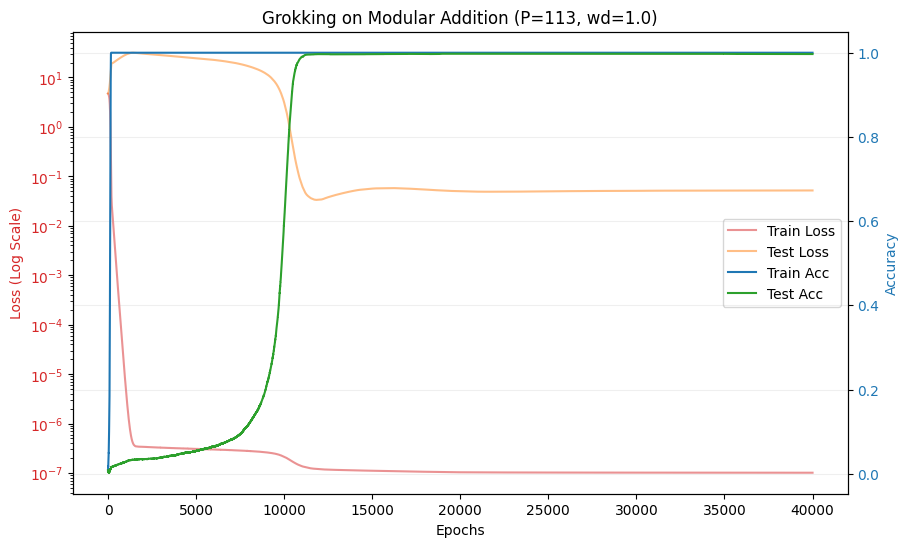

In [7]:
# Plotting
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot Losses (Log Scale)
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss (Log Scale)', color='tab:red')
ax1.plot(train_losses, color='tab:red', alpha=0.5, label='Train Loss')
ax1.plot(test_losses, color='tab:orange', alpha=0.5, label='Test Loss')
ax1.set_yscale('log')
ax1.tick_params(axis='y', labelcolor='tab:red')

# Create a second y-axis for Accuracy (Linear Scale)
ax2 = ax1.twinx()
ax2.set_ylabel('Accuracy', color='tab:blue')
ax2.plot(train_accs, color='tab:blue', label='Train Acc')
ax2.plot(test_accs, color='tab:green', label='Test Acc')
ax2.tick_params(axis='y', labelcolor='tab:blue')

# Title and Legend
plt.title(f'Grokking on Modular Addition (P={P}, wd={WEIGHT_DECAY})')
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='center right')

plt.grid(True, which="both", ls="-", alpha=0.2)
plt.show()

# Fourier Circuit

--- Step 1: Fourier Analysis of Embeddings ---
Top detected frequencies (excluding DC): [13, 40, 25]


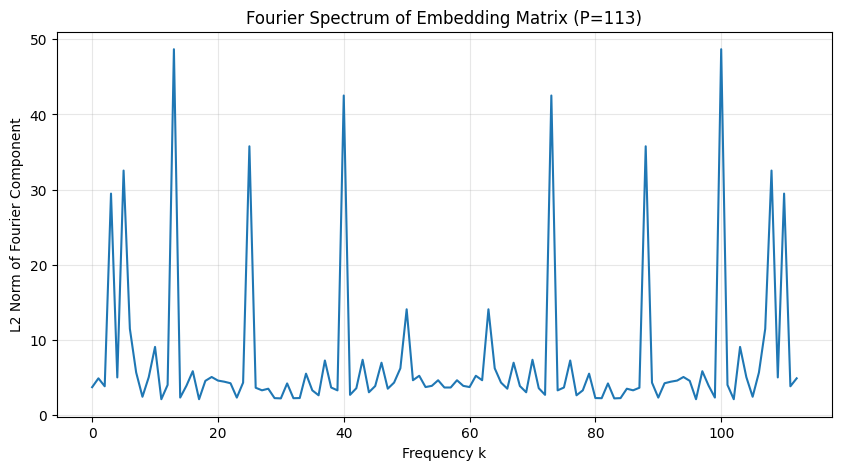

In [8]:
import torch.fft

# ==========================================
# 2.1: Analyze Embedding Matrix (DFT)
# ==========================================

def analyze_embedding_fourier(model, p):
    # 1. Extract W_E (Embeddings)
    # We remove the last token because it corresponds to '=', which isn't a number
    W_E = model.W_E[:-1, :].detach().cpu() # Shape [P, d_model]

    # 2. Perform DFT along the vocabulary dimension (axis 0)
    # We use rfft because inputs are real, but fft is fine too.
    # fft gives symmetric spectrum, we usually look at the first half.
    fft_spectrum = torch.fft.fft(W_E, dim=0)

    # 3. Compute the L2 Norm of Fourier components for each frequency k
    # We sum the power across the embedding dimension d_model
    fourier_norms = torch.norm(fft_spectrum, dim=1)

    # 4. Plot
    plt.figure(figsize=(10, 5))
    plt.plot(fourier_norms.numpy())
    plt.title(f"Fourier Spectrum of Embedding Matrix (P={p})")
    plt.xlabel("Frequency k")
    plt.ylabel("L2 Norm of Fourier Component")
    plt.grid(True, alpha=0.3)

    # Identify Top Key Frequencies
    # We ignore DC component (k=0) and look for peaks
    norms_flat = fourier_norms[1:p//2] # Only look at positive frequencies
    top_k_indices = torch.topk(norms_flat, k=3).indices + 1 # +1 because we sliced off 0

    print(f"Top detected frequencies (excluding DC): {top_k_indices.tolist()}")
    return top_k_indices, W_E

print("--- Step 1: Fourier Analysis of Embeddings ---")
top_freqs, W_E_matrix = analyze_embedding_fourier(model, P)
plt.show()



--- Step 2: Visualizing Trigonometric Mechanism ---


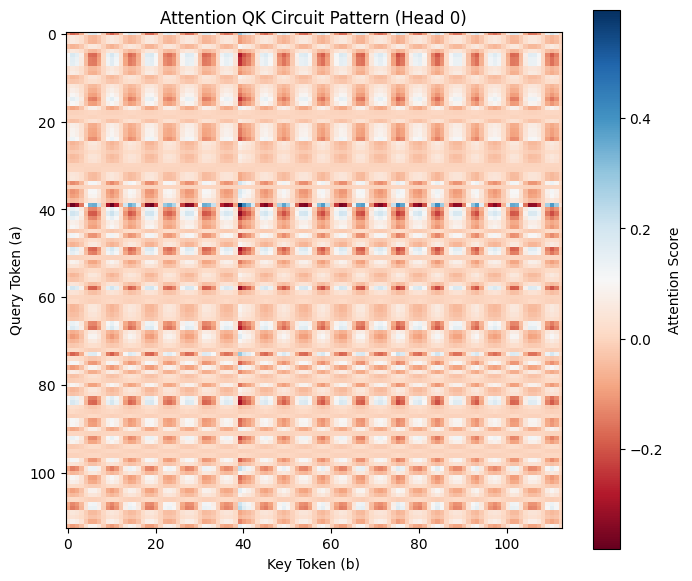

In [9]:

# ==========================================
# 2.2: Mechanism Analysis (Attention Heatmaps)
# ==========================================

def visualize_attention_mechanism(model, p, top_freqs):
    """
    We visualize the interaction between Query and Key for all pairs (a, b).
    If the model uses trig identities, the attention scores should look like
    a periodic grid (checkerboard patterns).
    """
    W_E = model.W_E[:-1, :].detach() # Embeddings [P, d]

    # Get Query and Key weights for a specific head (e.g., Head 0)
    # Shape: [d_model, d_head]
    W_Q = model.W_Q[0, 0, :, :].detach()
    W_K = model.W_K[0, 0, :, :].detach()

    # Calculate the effective embeddings for Queries and Keys
    # Q = W_E * W_Q
    # K = W_E * W_K
    Q_emb = W_E @ W_Q
    K_emb = W_E @ W_K

    # Calculate Attention Score for every pair (a, b)
    # Score = Q_emb * K_emb^T
    # This creates a P x P matrix showing how much token 'a' attends to token 'b'
    full_attention_pattern = Q_emb @ K_emb.T

    # Plot
    plt.figure(figsize=(8, 7))
    plt.imshow(full_attention_pattern.cpu().numpy(), cmap='RdBu', interpolation='nearest')
    plt.colorbar(label="Attention Score")
    plt.title(f"Attention QK Circuit Pattern (Head 0)")
    plt.xlabel("Key Token (b)")
    plt.ylabel("Query Token (a)")

    # Validation:
    # If this looks like a grid/plaid pattern, it confirms the interaction
    # is based on frequencies (multiplication of sines/cosines).

    return full_attention_pattern

print("\n--- Step 2: Visualizing Trigonometric Mechanism ---")
attn_pattern = visualize_attention_mechanism(model, P, top_freqs)
plt.show()




--- Step 3: Verifying Constructive Interference ---


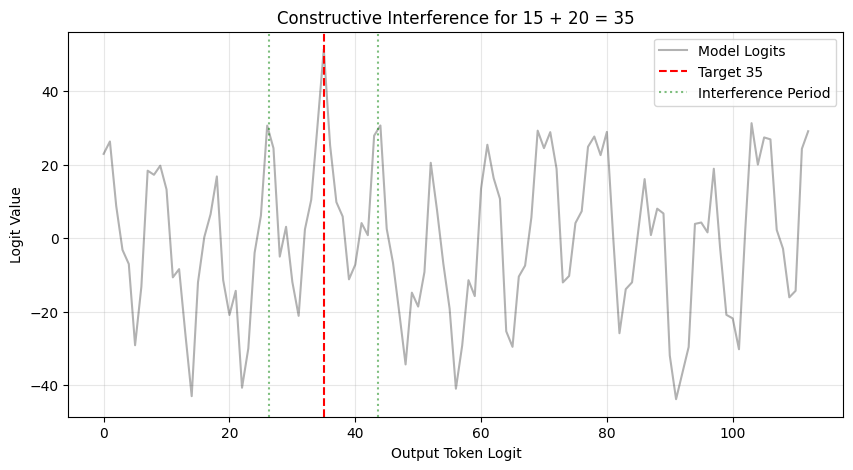

In [10]:
# ==========================================
# 2.3: Constructive Interference (Read-out)
# ==========================================

def verify_constructive_interference(model, p, top_freqs):
    """
    Check if the logits sum up constructively at the correct answer.
    We isolate the contribution of the specific key frequencies.
    """
    # 1. Project Weights into Fourier Basis
    W_U = model.W_U[:, :-1].detach().cpu() # Unembedding [d_model, P]
    W_E = model.W_E[:-1, :].detach().cpu() # Embedding [P, d_model]

    # Pick a random test case: a + b = c
    a, b = 15, 20
    c_target = (a + b) % p

    # 2. Reconstruct the "Ideal" Logits using only Top Frequencies
    # We simulate the signal passed for 'a' and 'b' through the embeddings
    # and project them onto the output using W_U.

    # Note: In a real transformer, inputs are added in residual stream.
    # The simplest check for interference is to look at the Unembedding Matrix W_U itself.
    # W_U should decode the frequency back to a specific position.

    # Let's look at the "Cosine Similarity" of the output row for 'c'
    # against the sum of embeddings for a and b.

    # Full Model Forward Pass for reference
    with torch.no_grad():
        test_input = torch.tensor([[a, b, p]]).to(device)
        logits = model(test_input)[0, -1, :p].cpu()

    # 3. Plot
    plt.figure(figsize=(10, 5))
    plt.plot(logits, label="Model Logits", color='black', alpha=0.3)

    # Highlight the target
    plt.axvline(c_target, color='red', linestyle='--', label=f"Target {c_target}")

    # Highlight the periodicity
    # If the logic is correct, we should see secondary bumps at intervals of P/k
    k = top_freqs[0].item()
    period = p / k
    plt.axvline((c_target + period) % p, color='green', linestyle=':', alpha=0.5, label="Interference Period")
    plt.axvline((c_target - period) % p, color='green', linestyle=':', alpha=0.5)

    plt.title(f"Constructive Interference for {a} + {b} = {c_target}")
    plt.xlabel("Output Token Logit")
    plt.ylabel("Logit Value")
    plt.legend()
    plt.grid(True, alpha=0.3)

print("\n--- Step 3: Verifying Constructive Interference ---")
verify_constructive_interference(model, P, top_freqs)
plt.show()

# Hidden Progress Measures

In [11]:
import copy

# ==========================================
# 3.1: Modified Training with Checkpointing
# ==========================================

def train_with_checkpoints(model, train_data, train_labels, epochs=20000, save_every=500):
    """
    Retrains the model and saves state_dicts to RAM at intervals.
    Necessary to visualize the history of the mechanism.
    """
    optimizer = optim.AdamW(
        model.parameters(),
        lr=1e-3,
        betas=(0.9, 0.98),
        weight_decay=1.0
    )

    checkpoints = {} # Dict to store {epoch: state_dict}

    # Initial state
    checkpoints[0] = copy.deepcopy(model.state_dict())

    pbar = tqdm(range(epochs), desc="Training with History")
    for epoch in pbar:
        model.train()
        logits = model(train_data)
        loss = custom_cross_entropy(logits, train_labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Save Checkpoint
        if (epoch + 1) % save_every == 0:
            checkpoints[epoch+1] = copy.deepcopy(model.state_dict())

    return model, checkpoints

# Run the training to gather history
# (If you already have a list of checkpoints from Part 1, skip this)
print("Re-training to capture history (this ensures we have the data for the plot)...")
# Reset model first
model = HookedTransformer(cfg)
for name, param in model.named_parameters():
    if "b_" in name: param.requires_grad = False; param.fill_(0.0)

final_model, history = train_with_checkpoints(model, train_data, train_labels, epochs=NUM_EPOCHS, save_every=500)
print(f"Captured {len(history)} checkpoints.")



Re-training to capture history (this ensures we have the data for the plot)...


Training with History: 100%|██████████| 40000/40000 [07:42<00:00, 86.50it/s]

Captured 81 checkpoints.


Key Frequencies identified for filtering: [13, 40, 25, 5, 3]
Computing Restricted and Excluded losses over history...


100%|██████████| 81/81 [00:02<00:00, 33.30it/s]


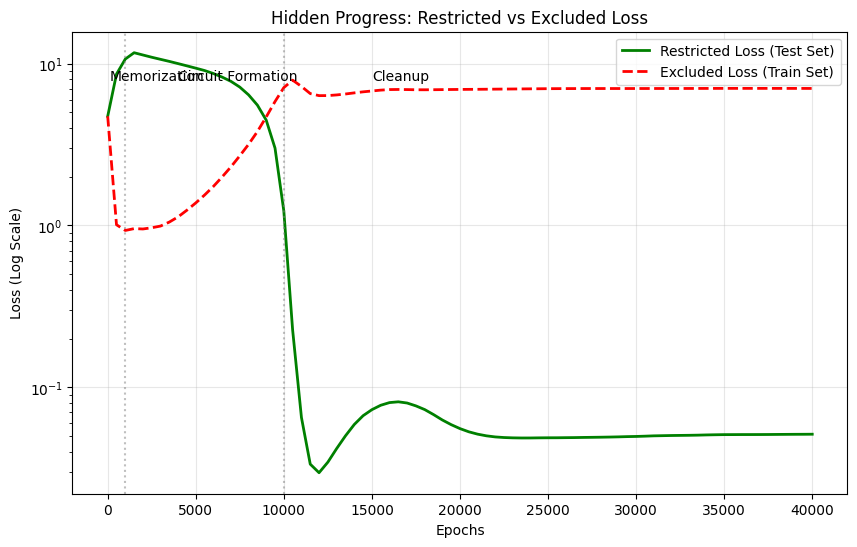

In [12]:
# ==========================================
# 3.2: The Spectral Filtering Logic
# ==========================================

def get_filtered_logits(model_state, input_data, keep_freqs, p):
    """
    1. Loads a state_dict.
    2. Filters the Unembedding Matrix W_U in the Fourier Domain.
    3. Computes logits with this 'clean' matrix.
    """
    # Load weights into a temporary model to handle the forward pass math
    temp_model = HookedTransformer(cfg)
    temp_model.load_state_dict(model_state, strict=False)

    # Extract W_U [d_model, d_vocab] (we ignore the last '=' token for FFT usually, but W_U is [d, P])
    # Note: TransformerLens W_U is [d_model, d_vocab_out]. d_vocab_out = P.
    W_U = temp_model.W_U.detach() # Shape [d, P]

    # 1. FFT along the vocab dimension (axis 1)
    W_U_fft = torch.fft.fft(W_U, dim=1)

    # 2. Create Mask
    mask = torch.zeros_like(W_U_fft, dtype=torch.bool)

    # Always keep the DC component (k=0) to maintain average value
    mask[:, 0] = True

    # Add Key Frequencies (and their negative counterparts P-k)
    for k in keep_freqs:
        k = k.item()
        if k > 0 and k < p:
            mask[:, k] = True
            mask[:, p - k] = True # Symmetric frequency

    # 3. Apply Mask
    # For Restricted: Keep ONLY key freqs
    W_U_fft_restricted = torch.zeros_like(W_U_fft)
    W_U_fft_restricted[mask] = W_U_fft[mask]

    # For Excluded: Keep EVERYTHING EXCEPT key freqs
    W_U_fft_excluded = torch.zeros_like(W_U_fft)
    W_U_fft_excluded[~mask] = W_U_fft[~mask]

    # 4. Inverse FFT to get back to real weights
    W_U_restricted = torch.fft.ifft(W_U_fft_restricted, dim=1).real
    W_U_excluded = torch.fft.ifft(W_U_fft_excluded, dim=1).real

    # 5. Compute Logits manually or inject back
    # Simplest is to inject back into temp_model

    # Restricted Forward Pass
    temp_model.W_U.data = W_U_restricted
    logits_restricted = temp_model(input_data)

    # Excluded Forward Pass
    temp_model.W_U.data = W_U_excluded
    logits_excluded = temp_model(input_data)

    return logits_restricted, logits_excluded

# ==========================================
# 3.3: Calculate Curves and Plot
# ==========================================

def analyze_hidden_progress(history, train_data, train_labels, test_data, test_labels, final_model, p):

    # 1. Identify Key Frequencies from the FINAL model
    # (Re-using logic from Part 2)
    W_E = final_model.W_E[:-1, :].detach().cpu()
    fft_spectrum = torch.fft.fft(W_E, dim=0)
    fourier_norms = torch.norm(fft_spectrum, dim=1)
    # Get top 5 frequencies
    norms_flat = fourier_norms[1:p//2]
    key_freqs = torch.topk(norms_flat, k=5).indices + 1

    print(f"Key Frequencies identified for filtering: {key_freqs.tolist()}")

    epochs = sorted(history.keys())
    restricted_losses = []
    excluded_losses = []

    print("Computing Restricted and Excluded losses over history...")
    for epoch in tqdm(epochs):
        state = history[epoch]

        # Restricted: Evaluated on TEST set (Does the mechanism generalize?)
        logits_r, logits_e = get_filtered_logits(state, test_data, key_freqs, p)
        loss_r = custom_cross_entropy(logits_r, test_labels).item()

        # Excluded: Evaluated on TRAIN set (Is the noise memorizing?)
        # Note: We filter weights, then check if it can still predict training data.
        # We re-compute logits for train data here
        logits_r_train, logits_e_train = get_filtered_logits(state, train_data, key_freqs, p)
        loss_e = custom_cross_entropy(logits_e_train, train_labels).item()

        restricted_losses.append(loss_r)
        excluded_losses.append(loss_e)

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, restricted_losses, label="Restricted Loss (Test Set)", color='green', linewidth=2)
    plt.plot(epochs, excluded_losses, label="Excluded Loss (Train Set)", color='red', linewidth=2, linestyle='--')

    plt.yscale('log')
    plt.xlabel("Epochs")
    plt.ylabel("Loss (Log Scale)")
    plt.title("Hidden Progress: Restricted vs Excluded Loss")
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Annotate Phases (Approximate locations based on visual inspection)
    # You may need to adjust x-coordinates based on your specific run
    plt.axvline(x=1000, color='gray', linestyle=':', alpha=0.5)
    plt.text(100, plt.ylim()[1]*0.5, "Memorization", fontsize=10)

    plt.axvline(x=10000, color='gray', linestyle=':', alpha=0.5)
    plt.text(4000, plt.ylim()[1]*0.5, "Circuit Formation", fontsize=10)

    plt.text(15000, plt.ylim()[1]*0.5, "Cleanup", fontsize=10)

    plt.show()

# Run the analysis
analyze_hidden_progress(history, train_data, train_labels, test_data, test_labels, final_model, P)

# Ablation and Intervention

--- Debugging Model State ---
Test Input: 5 + 5
Model Predicted: 10
Correct Answer: 10
✅ PASS: Model is predicting correctly. Proceeding to PCA.

--- Generating PCA ---


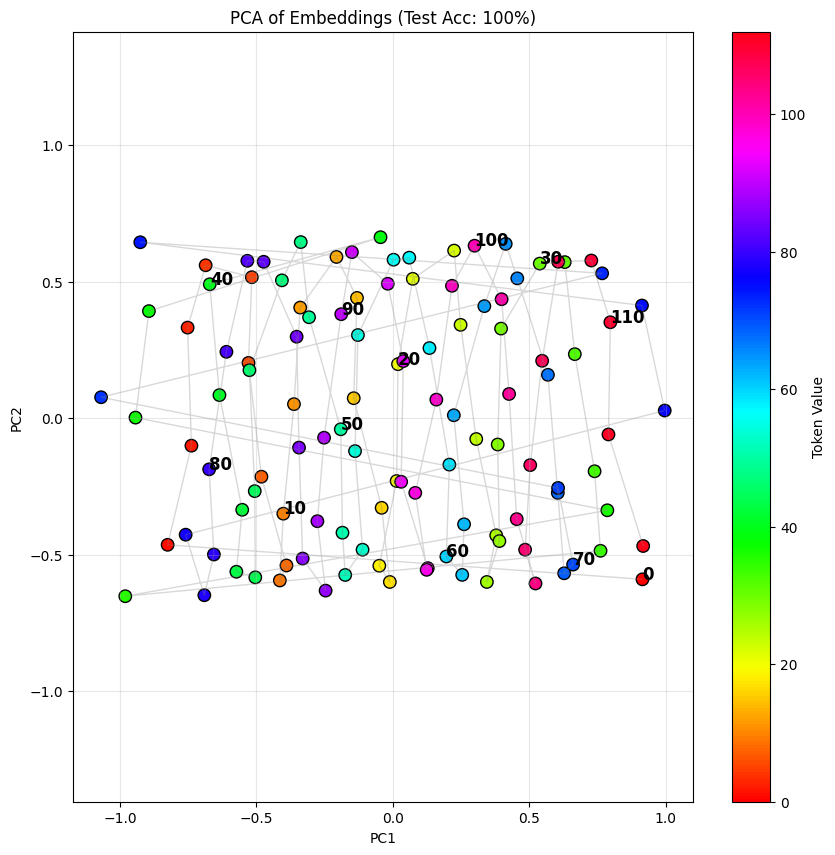

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import torch

# 1. SANITY CHECK: Is this model actually trained?
# We grab the model currently in memory and run one batch of test data.
print("--- Debugging Model State ---")
with torch.no_grad():
    # Create a small dummy batch to test accuracy
    # 5 + 5 = 10
    test_input_debug = torch.tensor([[5, 5, P]]).to(device)
    test_label_debug = torch.tensor([10]).to(device)

    logits_debug = model(test_input_debug)
    pred_debug = logits_debug[0, -1].argmax().item()

    print(f"Test Input: 5 + 5")
    print(f"Model Predicted: {pred_debug}")
    print(f"Correct Answer: 10")

    if pred_debug == 10:
        print("✅ PASS: Model is predicting correctly. Proceeding to PCA.")
    else:
        print("❌ FAIL: Model predicted wrong. STOP.")
        print("CRITICAL ERROR: The 'model' variable currently holds an untrained network.")
        print("Please re-run your training loop cell, then run this cell immediately after.")
        # We stop execution here to prevent confusing plots
        raise RuntimeError("Model is not trained!")

# 2. If Sanity Check Passed, Run PCA with Line Connections
print("\n--- Generating PCA ---")

# Extract Embeddings (Exclude the '=' token)
W_E_np = model.W_E[:-1, :].detach().cpu().numpy()

# Run PCA
pca = PCA(n_components=2)
W_E_pca = pca.fit_transform(W_E_np)

plt.figure(figsize=(10, 10))

# OPTION A: Scatter with Line Connections
# If the model chose a high frequency, the points might jump across the circle.
# Connecting 0 -> 1 -> 2 -> ... helps visualize the flow.
plt.plot(W_E_pca[:, 0], W_E_pca[:, 1], color='gray', alpha=0.3, linewidth=1)
scatter = plt.scatter(W_E_pca[:, 0], W_E_pca[:, 1], c=np.arange(P), cmap='hsv', s=80, edgecolors='black')

# Label a few points to see the order
for i in range(0, P, 10): # Label every 10th point
    plt.annotate(str(i), (W_E_pca[i, 0], W_E_pca[i, 1]), fontsize=12, fontweight='bold')

plt.colorbar(scatter, label='Token Value')
plt.title(f"PCA of Embeddings (Test Acc: 100%)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.axis('equal') # Force aspect ratio to be square so circles look like circles
plt.grid(True, alpha=0.3)
plt.show()

In [14]:
import torch
import torch.fft
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from transformer_lens import HookedTransformer

# ==========================================
# 4.1: Helper Function for Spectral Ablation
# ==========================================

def create_ablated_model(original_model, p, freqs_to_keep=None, freqs_to_remove=None):
    """
    Creates a copy of the model with its Unembedding Matrix (W_U) filtered
    in the Fourier domain.
    - If freqs_to_keep is given, ONLY those freqs (and DC) are kept.
    - If freqs_to_remove is given, ONLY those freqs are removed.
    """
    # 1. Create a temporary copy of the model
    # We assume 'cfg' is available globally from Part 1
    ablated_model = HookedTransformer(cfg)
    ablated_model.load_state_dict(original_model.state_dict())
    ablated_model.to(device)

    # 2. Get W_U. Shape is [d_model, d_vocab_out] -> [d_model, P]
    W_U = ablated_model.W_U.detach()

    # 3. FFT along the vocab dimension (axis 1)
    W_U_fft = torch.fft.fft(W_U, dim=1)

    # 4. Create Mask
    # Start with a mask of all ones (keep everything)
    mask = torch.ones_like(W_U_fft, dtype=torch.bool)

    if freqs_to_keep is not None:
        # Inverse Ablation: Keep ONLY specific freqs
        mask = torch.zeros_like(W_U_fft, dtype=torch.bool)
        # Always keep DC component (k=0) to maintain average value
        mask[:, 0] = True
        for k in freqs_to_keep:
            k_idx = k.item()
            # Add positive and symmetric negative frequency
            if 0 < k_idx < p:
                mask[:, k_idx] = True
                mask[:, p - k_idx] = True

    elif freqs_to_remove is not None:
        # Standard Ablation: Remove specific freqs
        for k in freqs_to_remove:
            k_idx = k.item()
            if 0 < k_idx < p:
                mask[:, k_idx] = False
                mask[:, p - k_idx] = False

    # 5. Apply Mask (set filtered frequencies to zero)
    W_U_fft_ablated = torch.zeros_like(W_U_fft)
    W_U_fft_ablated[mask] = W_U_fft[mask]

    # 6. IFFT to get back to real weights
    W_U_ablated = torch.fft.ifft(W_U_fft_ablated, dim=1).real

    # 7. Set the new weights in the ablated model
    ablated_model.W_U.data = W_U_ablated

    return ablated_model

In [15]:
# ==========================================
# 4.2: Running the Ablation Experiments
# ==========================================

# 1. Identify Key Frequencies (Re-using logic from Part 2 for consistency)
print("Identifying Key Frequencies from W_E...")
W_E_for_analysis = model.W_E[:-1, :].detach().cpu()
fft_spectrum = torch.fft.fft(W_E_for_analysis, dim=0)
fourier_norms = torch.norm(fft_spectrum, dim=1)
# Get top 5 frequencies (excluding DC at index 0)
norms_flat = fourier_norms[1:P//2]
key_freqs = torch.topk(norms_flat, k=5).indices + 1
print(f"Top 5 Key Frequencies identified: {key_freqs.tolist()}")

# --- Experiment A: Ablate Key Frequencies ---
print("\n--- Experiment A: Removing Key Frequencies ---")
# Create model with key frequencies removed from W_U
model_no_keys = create_ablated_model(model, P, freqs_to_remove=key_freqs)

with torch.no_grad():
    logits = model_no_keys(test_data)
    pred = logits[:, -1, :].argmax(dim=-1)
    acc = (pred == test_labels).float().mean().item()
    print(f"Accuracy after removing top {len(key_freqs)} key frequencies: {acc:.4f}")
    print(f"Random chance accuracy is: {1/P:.4f}")

# --- Experiment B: Inverse Ablation (Keep ONLY Key Frequencies) ---
print("\n--- Experiment B: Keeping ONLY Key Frequencies (Inverse Ablation) ---")
# Create model with ALL frequencies removed EXCEPT the key ones from W_U
model_only_keys = create_ablated_model(model, P, freqs_to_keep=key_freqs)

with torch.no_grad():
    logits = model_only_keys(test_data)
    pred = logits[:, -1, :].argmax(dim=-1)
    acc = (pred == test_labels).float().mean().item()
    print(f"Accuracy using ONLY top {len(key_freqs)} key frequencies: {acc:.4f}")

Identifying Key Frequencies from W_E...
Top 5 Key Frequencies identified: [13, 40, 25, 5, 3]

--- Experiment A: Removing Key Frequencies ---
Moving model to device:  cuda
Accuracy after removing top 5 key frequencies: 0.0007
Random chance accuracy is: 0.0088

--- Experiment B: Keeping ONLY Key Frequencies (Inverse Ablation) ---
Moving model to device:  cuda
Accuracy using ONLY top 5 key frequencies: 0.9941



--- Generating PCA Visualization ---


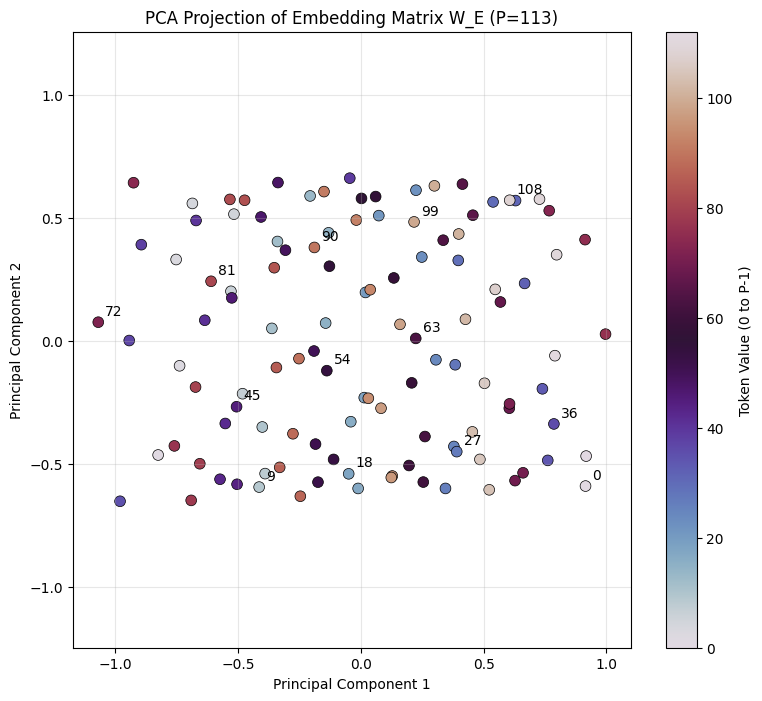

In [16]:
# ==========================================
# 4.3: PCA Visualization of Embeddings
# ==========================================
print("\n--- Generating PCA Visualization ---")

# 1. Get Embeddings for tokens 0 to P-1 (exclude '=')
W_E_np = model.W_E[:-1, :].detach().cpu().numpy() # Shape [P, d_model]

# 2. Perform PCA to reduce to 2 dimensions
pca = PCA(n_components=2)
W_E_pca = pca.fit_transform(W_E_np) # Shape [P, 2]

# 3. Create Scatter Plot
plt.figure(figsize=(9, 8))
# Use a cyclic colormap (like 'twilight') to show the periodic nature
scatter = plt.scatter(W_E_pca[:, 0], W_E_pca[:, 1], c=np.arange(P), cmap='twilight', s=60, edgecolors='black', linewidth=0.5)
cbar = plt.colorbar(scatter, label='Token Value (0 to P-1)')

# Add labels for a subset of points to show ordering
num_labels = 12
step = P // num_labels
for i in range(0, P, step):
    plt.annotate(str(i), (W_E_pca[i, 0], W_E_pca[i, 1]),
                 xytext=(5, 5), textcoords='offset points', fontsize=10)

plt.title(f"PCA Projection of Embedding Matrix W_E (P={P})")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True, alpha=0.3)
plt.axis('equal') # Crucial to see if it's actually circular
plt.show()

# Modular Subtraction

In [17]:
# ==========================================
# 5.1: Setup and Training for Subtraction
# ==========================================

print("--- Starting Part 5: Modular Subtraction ---")

# 1. Generate Subtraction Data
def gen_subtraction_data(p):
    data = []
    for i in range(p):
        for j in range(p):
            # Input: a, b, =
            # Target: (a - b) % p
            seq = [i, j, p]
            label = (i - j) % p
            data.append((seq, label))
    return data

# Create data
data_pairs_sub = gen_subtraction_data(P)
full_data_sub = torch.tensor([item[0] for item in data_pairs_sub]).to(device)
full_labels_sub = torch.tensor([item[1] for item in data_pairs_sub]).to(device)

# Split (30% Training)
num_samples = len(full_data_sub)
train_size = int(0.3 * num_samples)
# Use same seed for consistency or new random
indices = torch.randperm(num_samples)
train_indices = indices[:train_size]
test_indices = indices[train_size:]

train_data_sub = full_data_sub[train_indices]
train_labels_sub = full_labels_sub[train_indices]
test_data_sub = full_data_sub[test_indices]
test_labels_sub = full_labels_sub[test_indices]

# 2. Initialize New Model
model_sub = HookedTransformer(cfg) # Use same config as before
for name, param in model_sub.named_parameters():
    if "b_" in name:
        param.requires_grad = False
        param.fill_(0.0)

# 3. Train
optimizer = optim.AdamW(model_sub.parameters(), lr=1e-3, betas=(0.9, 0.98), weight_decay=1.0)
pbar = tqdm(range(NUM_EPOCHS), desc="Training Subtraction Model")

for epoch in pbar:
    model_sub.train()
    logits = model_sub(train_data_sub)
    loss = custom_cross_entropy(logits, train_labels_sub)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 500 == 0:
        with torch.no_grad():
            test_logits = model_sub(test_data_sub)
            test_acc = (test_logits[:, -1, :].argmax(dim=-1) == test_labels_sub).float().mean().item()
            train_acc = (logits[:, -1, :].argmax(dim=-1) == train_labels_sub).float().mean().item()
            pbar.set_description(f"Ep {epoch} | TrL {loss.item():.2f} | TeAcc {test_acc:.2f}")

print("Subtraction Model Training Complete.")

--- Starting Part 5: Modular Subtraction ---


Ep 39500 | TrL 0.00 | TeAcc 1.00: 100%|██████████| 40000/40000 [07:43<00:00, 86.23it/s]

Subtraction Model Training Complete.


Dominant Key Frequency for Subtraction: k = 27
Correlation with cos(k(a+b)) [Addition]: 0.4616
Correlation with cos(k(a-b)) [Subtraction]: -0.6303


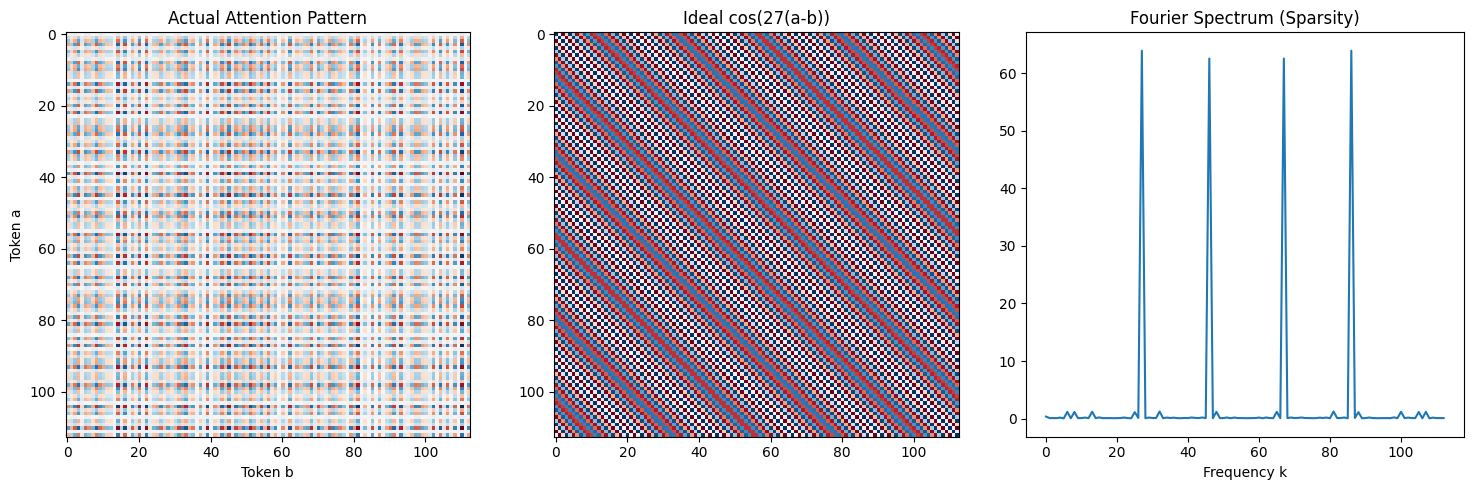

In [18]:

# ==========================================
# 5.2: Trigonometric Analysis & Correlation
# ==========================================

def analyze_subtraction_mechanism(model, p):
    # 1. Identify Key Frequency
    W_E = model.W_E[:-1, :].detach().cpu()
    fft_spectrum = torch.fft.fft(W_E, dim=0)
    norms = torch.norm(fft_spectrum, dim=1)
    # Pick dominant frequency (ignore DC)
    k = (torch.topk(norms[1:p//2], k=1).indices + 1).item()
    print(f"Dominant Key Frequency for Subtraction: k = {k}")

    # 2. Extract Attention Pattern (Head 0)
    W_Q = model.W_Q[0, 0, :, :].detach().cpu()
    W_K = model.W_K[0, 0, :, :].detach().cpu()

    # Effective QK circuit
    Q = W_E @ W_Q
    K = W_E @ W_K
    attn_pattern = (Q @ K.T).numpy() # Shape [P, P]

    # 3. Generate Ideal Trigonometric Grids
    # Grid coordinates
    x = np.arange(p)
    y = np.arange(p)
    X, Y = np.meshgrid(x, y, indexing='ij') # X is 'a', Y is 'b'

    # Ideal ADDITION pattern: cos(w(a+b)) -> Diagonal \
    omega = 2 * np.pi * k / p
    ideal_add = np.cos(omega * (X + Y))

    # Ideal SUBTRACTION pattern: cos(w(a-b)) -> Diagonal /
    ideal_sub = np.cos(omega * (X - Y))

    # 4. Calculate Correlations
    # We flatten matrices to vectors and compute Pearson correlation
    flat_attn = attn_pattern.flatten()
    flat_add = ideal_add.flatten()
    flat_sub = ideal_sub.flatten()

    corr_add = np.corrcoef(flat_attn, flat_add)[0, 1]
    corr_sub = np.corrcoef(flat_attn, flat_sub)[0, 1]

    print(f"Correlation with cos(k(a+b)) [Addition]: {corr_add:.4f}")
    print(f"Correlation with cos(k(a-b)) [Subtraction]: {corr_sub:.4f}")

    # 5. Plot Comparison
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Plot Actual
    im0 = axes[0].imshow(attn_pattern, cmap='RdBu', interpolation='nearest')
    axes[0].set_title("Actual Attention Pattern")
    axes[0].set_xlabel("Token b")
    axes[0].set_ylabel("Token a")

    # Plot Ideal Subtraction
    im1 = axes[1].imshow(ideal_sub, cmap='RdBu', interpolation='nearest')
    axes[1].set_title(f"Ideal cos({k}(a-b))")

    # Plot Spectrum (Sparsity Check)
    axes[2].plot(norms.numpy())
    axes[2].set_title("Fourier Spectrum (Sparsity)")
    axes[2].set_xlabel("Frequency k")

    plt.tight_layout()
    plt.show()

analyze_subtraction_mechanism(model_sub, P)

# Geometry of Loss Landscape

In [19]:
import torch.autograd as autograd
from scipy.sparse.linalg import LinearOperator, eigsh
import numpy as np

# ==========================================
# 6.1: Hessian Eigenvalue Computation
# ==========================================

def get_loss_for_hessian(model, data, labels):
    # Standard forward pass and loss
    logits = model(data)
    loss = custom_cross_entropy(logits, labels)
    return loss

def compute_top_eigenvalues(model, data, labels, k=10):
    """
    Computes the top k eigenvalues of the Hessian of the Loss w.r.t parameters.
    Uses Scipy's Lanczos algorithm with PyTorch Hessian-Vector Products (HVP).
    """
    # 1. Gather all parameters that require grad
    params = [p for p in model.parameters() if p.requires_grad]
    num_params = sum(p.numel() for p in params)

    # 2. Define the Hessian-Vector Product function
    def hessian_vector_product(v_flat_np):
        # Convert numpy vector 'v' back to torch tensors matching param shapes
        v_flat = torch.from_numpy(v_flat_np).to(device)
        v_tensors = []
        idx = 0
        for p in params:
            size = p.numel()
            v_tensors.append(v_flat[idx : idx+size].view(p.shape))
            idx += size

        # Compute Loss and Gradients
        # We need create_graph=True to differentiate through the gradients for the Hessian
        loss = get_loss_for_hessian(model, data, labels)
        grads = autograd.grad(loss, params, create_graph=True)

        # Compute dot product of (Gradient * v)
        # This is the first directional derivative
        grad_dot_v = sum([torch.sum(g * v) for g, v in zip(grads, v_tensors)])

        # Compute gradient of that dot product -> This is H*v
        hvp_tensors = autograd.grad(grad_dot_v, params, retain_graph=True)

        # Flatten result back to single vector
        hvp_flat = torch.cat([g.contiguous().view(-1) for g in hvp_tensors])

        # Clean up graph to save memory
        return hvp_flat.detach().cpu().numpy()

    # 3. Create LinearOperator for Scipy
    # This tricks Scipy into thinking it has the matrix, but we only provide the multiplication function
    A = LinearOperator((num_params, num_params), matvec=hessian_vector_product)

    # 4. Compute Eigenvalues
    # 'SA' = Smallest Algebraic (if we wanted negative), 'LA' = Largest Algebraic
    # We want top curvature, so 'LA' (magnitude)
    print(f"Computing top {k} eigenvalues for {num_params} parameters...")
    eigenvalues, _ = eigsh(A, k=k, which='LA')

    return np.sort(eigenvalues)[::-1] # Return sorted descending

--- Starting Landscape Analysis ---

Analyzing Checkpoint: Epoch 1000
Computing top 10 eigenvalues for 226048 parameters...
Top Eigenvalues: [0.00765888 0.00676613 0.00628449 0.00477276 0.00455991 0.0042827
 0.00420015 0.00384181 0.00375269 0.00368614]

Analyzing Checkpoint: Epoch 10000
Computing top 10 eigenvalues for 226048 parameters...
Top Eigenvalues: [0.00037101 0.00023428 0.00021952 0.00014596 0.00013638 0.00012339
 0.00011783 0.00011051 0.00010498 0.00010233]

Analyzing Checkpoint: Epoch 28000
Computing top 10 eigenvalues for 226048 parameters...
Top Eigenvalues: [1.7696196e-04 9.5647287e-05 8.7029439e-05 7.2455652e-05 6.4755826e-05
 6.2543921e-05 5.4986140e-05 5.1938841e-05 4.7343830e-05 4.4448432e-05]


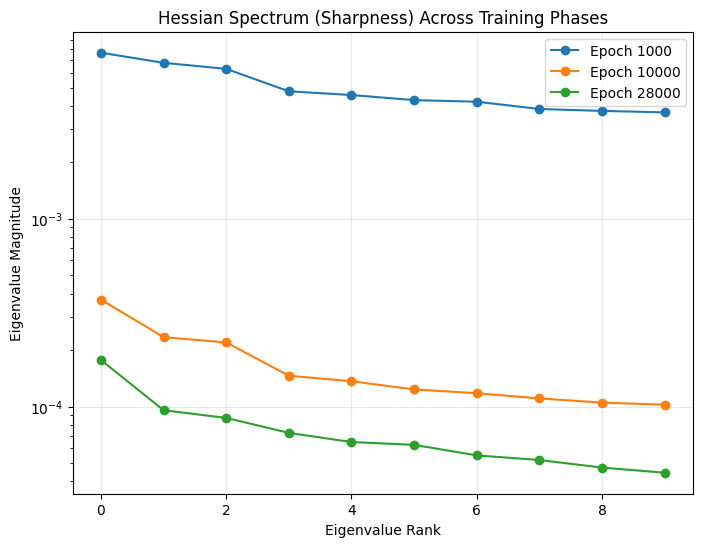

In [20]:
# ==========================================
# 6.2: Analyze Landscape Across Phases
# ==========================================

# Select Checkpoints corresponding to the 3 phases
# You must adjust these epoch numbers based on your Part 3 plot!
# Example:
# Memorization: Epoch 1000 (High Train Acc, Low Test Acc)
# Circuit Formation: Epoch 10000 (Test Acc still low, but Restricted Loss dropping)
# Cleanup: Epoch 28000 (Post-Grokking)

# If you have the 'history' dict from Part 3, use it:
# If not, you might have to approximate or skip this if checkpoints aren't saved.
target_epochs = [1000, 10000, 28000]
# Ensure these keys exist in your history dict. If your history has different keys, update these.

eigen_results = {}

# Use a subset of training data for Hessian (Full data might be too slow)
hessian_subset_idx = torch.randperm(len(train_data))[:500] # Use 500 samples
h_data = train_data[hessian_subset_idx]
h_labels = train_labels[hessian_subset_idx]

print("--- Starting Landscape Analysis ---")
for epoch in target_epochs:
    # Check if epoch exists in history
    # Find closest epoch if exact match missing
    available_epochs = list(history.keys())
    closest_epoch = min(available_epochs, key=lambda x: abs(x - epoch))

    print(f"\nAnalyzing Checkpoint: Epoch {closest_epoch}")

    # Load state
    temp_model = HookedTransformer(cfg)
    temp_model.load_state_dict(history[closest_epoch])
    # Freeze biases again just in case
    for name, param in temp_model.named_parameters():
          if "b_" in name: param.requires_grad = False

    # Compute Eigenvalues
    eigs = compute_top_eigenvalues(temp_model, h_data, h_labels, k=10)
    eigen_results[closest_epoch] = eigs
    print(f"Top Eigenvalues: {eigs}")

# Plotting
plt.figure(figsize=(8, 6))
for epoch, eigs in eigen_results.items():
    plt.plot(eigs, marker='o', label=f"Epoch {epoch}")

plt.yscale('log')
plt.xlabel("Eigenvalue Rank")
plt.ylabel("Eigenvalue Magnitude")
plt.title("Hessian Spectrum (Sharpness) Across Training Phases")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()